In [28]:
from solcore import si
from solcore import material
from solcore.solar_cell import SolarCell, Layer, Junction
from solcore.solar_cell_solver import solar_cell_solver, default_options
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [29]:
T = 300
wavelengths_optics = np.linspace(300, 1200, 800)*1e-9

Define some materials and layer widths:

In [30]:
Si = material("Si")
SiO2 = material("SiO2")()

In [31]:
n_material = Si(T=T, Nd=si(1e21, "cm-3"), hole_diffusion_length=si("50um"),
                electron_mobility=50e-4, relative_permittivity = 11.68)
p_material = Si(T=T, Na=si(1e16, "cm-3"), electron_diffusion_length=si("150um"),
                hole_mobility=400e-4, relative_permittivity = 11.68)

In [32]:
ARC_width = si("100nm")
n_material_width = si("500nm")
p_material_width = si("50um")

We are first going to get some optics data which we can then use to illustrate how to provide
the relevant quantities to the external optics solver. Obviously, this is a bit circular, since we
are first going to use Solcore to calculate reflection and absorption and then feed that information
back into solar_cell_solver in a different format, but this way we can show how the data should be
provided when using external optics and that everything is working consistently.

In [33]:
solar_cell = SolarCell(
    [
        Layer(width=ARC_width, material=SiO2),
        Junction([Layer(width=n_material_width, material=n_material, role='emitter'),
                  Layer(width=p_material_width, material=p_material, role='base'),
		 ], sn=1, sp=1, kind='DA'),
    ])

In [34]:
total_width = ARC_width + n_material_width + p_material_width

options: we are going to use TMM to calculate the optics of a silicon cell with a 100 nm SiO2 anti-reflection coating<br>
This will not be very realistic<br>
compared to a standard Si cell, which will usually have some textured surface (usually pyramids) and not just a planar<br>
surface with an anti-reflection coating, but it gives some physically reasonable data to use.

In [35]:
options = default_options
options.optics_method = "TMM"
options.wavelength = wavelengths_optics
# options.position = np.linspace(0, total_width, 100000)
options.light_iv = True
V = np.linspace(0, 1.2, 200)

In [36]:
solar_cell_solver(solar_cell, 'iv', options)

Solving optics of the solar cell...
Treating layer(s) 2 incoherently
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


/home/phoebe/Documents/solcore5/solcore/absorption_calculator/tmm_core_vec.py:1075: ComplexWarning: Casting complex values to real discards the imaginary part
  A_local[:, layer == l] = A_layer


Now we are going to get the relevant data to see how we might construct
appropriate functions to provide external optics data to Solcore. If you are
using experimental data, this could be loaded from a file, here we will take it
from the TMM calculations done above. We get the fraction of light reflected,
and the fraction of light absorbed in the Si layer.

In [37]:
reflected = solar_cell.reflected
absorbed_in_Si = solar_cell[1].layer_absorption

We need to provide two attributes when defining the cell to give all the required
information for external optics: external_reflected and external_absorbed. external_reflected<
is a list of the fraction of incident light reflected at each wavelength that is specified in the user options.
external_absorbed is a function which takes as input an array of positions (depths)
in the cell in m and returns the differential absorption at each wavelength and depth; this is
a 2D numpy array where the first dimension is over the wavelengths and the second dimension
is over the positions in the cell.

We could take the diff_absorption method from solar_cell, which was constructed during the TMM
calculation done above, but in order to show how the absorption profile can be calculated from
total absorption in a layer (assuming Beer-Lambert law absorption, i.e. no interference in the layer)
we will define a function which calculates the differential absorption from just the total absorption
and the absorption coefficient of the junction material.

To illustrate how you can use data from e.g. an experiment to perform calculations at different wavelength,
we're going to take the data we calculated above but use slightly different wavelength points.

Interpolate reflection and total absorption in Si to the new wavelengths:

In [38]:
interp_ref = interp1d(options.wavelength, reflected)
interp_totalA = interp1d(options.wavelength, solar_cell[1].layer_absorption)

In [39]:
wavelengths_external = np.linspace(301, 1199, 800)*1e-9

In [40]:
alpha = n_material.alpha(wavelengths_external)
A_layer = interp_totalA(wavelengths_external)

Make function which returns the absorption profile. The functional form can be found by differentiating the<br>
Beer-Lambert law, and making sure it is normalized correctly to give the expected total absorption

In [41]:
junction_width = n_material_width + p_material_width

In [42]:
def make_absorb_fn(alpha, A_layer, junction_width):
    norm = A_layer * alpha / (1 - np.exp(-alpha * junction_width))
    def profile(z):
        xy = norm[None, :] * np.exp(-alpha * z[:, None])
        return xy.T
    return profile

In [43]:
diff_absorb_fn = make_absorb_fn(alpha, A_layer, junction_width)

We now define a solar cell for the external optics calculation. It's the same as solar_cell,
but without the ARC layer; this does not do anything in the electrical calculation, and we must
omit it so that the diff_absorb_fn defined above works correctly. This function should describe the
differential absorption profile in the WHOLE cell, including any surface layers,
but to avoid complexity in make_absorb_fn it just calculates
Beer-Lambert absorption in the Si and ignores the ARC. So for the absorption profile to match the actual
cell, we need the front surface to be the Si emitter.

In [44]:
solar_cell_external = SolarCell(
    [
        Junction([Layer(width=n_material_width, material=n_material, role='emitter'),
                  Layer(width=p_material_width, material=p_material, role='base'),
		 ], sn=1, sp=1, kind='DA'),
    ], external_reflected=interp_ref(wavelengths_external), external_absorbed=diff_absorb_fn)

In [45]:
options.optics_method = "external"
options.wavelength = wavelengths_external

In [46]:
solar_cell_solver(solar_cell_external, 'iv', options)

Solving optics of the solar cell...
0
Solving IV of the junctions...
0
0
0
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


Check that the total absorption and reflection are the same. The total reflection will be the same<br>
as it is directly supplied by the user, but the total reflection is calculated by integrating the<br>
differential absorption, so this is a good check:

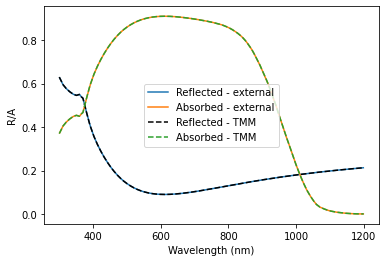

In [47]:
plt.figure()
plt.plot(wavelengths_external*1e9, solar_cell_external.reflected, label='Reflected - external')
plt.plot(wavelengths_external*1e9, solar_cell_external.absorbed, label='Absorbed - external')
plt.plot(wavelengths_optics*1e9, reflected, 'k--', label='Reflected - TMM')
plt.plot(wavelengths_optics*1e9, absorbed_in_Si, '--', label='Absorbed - TMM')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('R/A')
plt.show()

Compare the light-IV curves:

Text(0.5, 0, 'Voltage (V)')

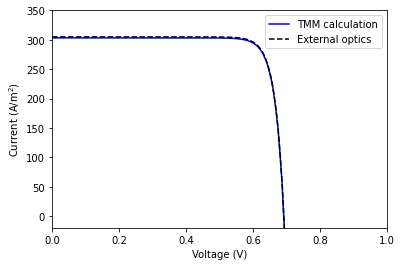

In [48]:
plt.figure(1)
plt.plot(V, -solar_cell[1].iv(V), 'b', label='TMM calculation')
plt.plot(V, -solar_cell_external[0].iv(V), 'k--', label='External optics')
plt.legend()
plt.ylim(-20, 350)
plt.xlim(0, 1)
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)') #The expected values of Isc and Voc are 372 A/m^2 and 0.63 V respectively

In [49]:
plt.show()

Finally, compare the absorption profiles (diff_absorption). These will not be exactly identical,
because the profile for the TMM cell also contains the absorption profile in the ARC (= 0 everywhere),
so is shifted over by 100 nm.

In [50]:
position_plot = np.linspace(0, 200, 100)*1e-9

In [51]:
absorption_profile_TMM = solar_cell[0].diff_absorption(position_plot)
absorption_profile_constructed = solar_cell_external[0].diff_absorption(position_plot)

Text(0.5, 1.0, 'Differential absorption (m$^{-1}$) in front surface of cell')

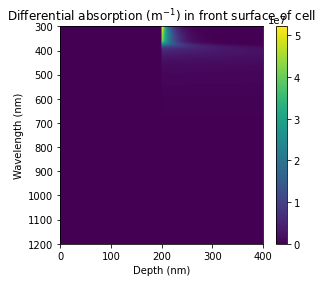

In [52]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(absorption_profile_TMM, aspect='auto', extent=[0, 400, 1200, 300])
plt.colorbar()
plt.xlabel('Depth (nm)')
plt.ylabel('Wavelength (nm)')
plt.title(r'Differential absorption (m$^{-1}$) in front surface of cell')

Text(0, 0.5, 'Wavelength (nm)')

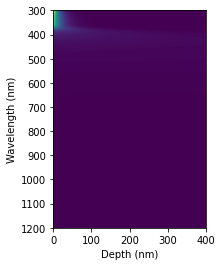

In [53]:
plt.subplot(122)
plt.imshow(absorption_profile_constructed, aspect='auto', extent=[0, 400, 1200, 300])
plt.xlabel('Depth (nm)')
plt.ylabel('Wavelength (nm)')

In [54]:
plt.show()